# Wrapping Libraries - Redback Example

This notebook is part of a series demonstrating how users can add support for their own simulation packages by adding simple wrappers. The example covered in this notebook is the [redback package](https://github.com/nikhil-sarin/redback) for transient modeling and fitting. Note that the redback package is not installed as part of the default LightCurveLynx installation. Users will need to manually install it via pip (e.g. `pip install redback`) in order to run this notebook.

For a demonstration on just how to use the redback wrapper, see the the redback_example notebook.

## Redback

[Redback](https://github.com/nikhil-sarin/redback) is a package for simulating and fitting a wide range of transient phenomena. All models in redback are implemented as functions with the given arguments defining their behavior. For example, we could load the "one_component_kilonova_model" from the library as:

In [1]:
import numpy as np

from redback import model_library

rb_model = model_library.all_models_dict["one_component_kilonova_model"]
print(type(rb_model))  # <class 'function'>

No module named 'lalsimulation'
lalsimulation is not installed. Some EOS based models will not work. Please use bilby eos or pass your own EOS generation class to the model
10:26 bilby INFO    : Running bilby version: 2.7.1
10:26 redback INFO    : Running redback version: 1.12.1


<class 'function'>


The redback documentation and code do a good job explaining the functions, what values they take, and what values they produce. For completeness, let’s look at the expected function arguments via introspection.

In [ ]:
import inspect

sig = inspect.signature(rb_model)
print(sig)

(time, redshift, mej, vej, kappa, **kwargs)


The keyword arguments hide a lot of options. One of the most important ones is ``output_format`` which determines what is computed and the format in which it is returned. For this notebook we will use ``output_format="sncosmo_source"`` which returns the output as a SED grid that can be queried for values at specific times and wavelengths.

In [3]:
rb_result = rb_model(
    np.linspace(-200, 200, 1000),  # times
    redshift=0.01,
    mej=0.05,
    vej=0.2,
    kappa=1.0,
    output_format="sncosmo_source",
)
print(rb_result)

class      : RedbackTimeSeriesSource
name       : None
version    : None
phases     : [1.16898e-08, .., 81.8287] days
wavelengths: [100, .., 60000] Angstroms
parameters:
  amplitude = np.float64(1.0)


## Wrapping Redback Models

To wrap a redback model we need to design a subclass of LightCurveLynx's `BasePhysicalModel` that:
1) takes the redback function,
2) sets its parameters, and 
3) queries the flux that it produces (returning the results in nJy). 

To wrap this as a LightCurveLynx model, we will need two functions:
* ``__init__()`` - Set up the internal data and register the (settable) parameters.
* ``compute_bandflux()`` - Compute the flux values (in nJy) at given times and filters.

**NOTE**: It is critical to understand the units of both the input and the output for each library. Redback produces output as f_lambda in erg / second / cm**2 / AA. LightCurveLynx expects the output as f_nu in nJy. So our computation function will need to make the appropriate conversions.

Since the redback models (with ``output_format="sncosmo_source"``) produce the full SED, we inherit our new class from the ``SEDModel`` class.

In [4]:
import astropy.units as uu

from lightcurvelynx.astro_utils.unit_utils import flam_to_fnu
from lightcurvelynx.models.physical_model import SEDModel


class SimpleRedbackWrapperModel(SEDModel):
    """A demo wrapper for redback models.

    Attributes
    ----------
    source : function
        The underlying source function that maps time + wavelength to flux.
    source_param_names : list
        A list of the source model's parameters that we need to set.

    Parameters
    ----------
    source : function
        The redback model function used to generate the SEDs.
    parameters : dict
        A dictionary of parameter setters to pass to the source function.
    **kwargs : dict, optional
        Any additional keyword arguments.
    """

    def __init__(self, source, parameters, **kwargs):
        # Call the base class constructor to set up the functionality
        # of a physical model.
        super().__init__(**kwargs)

        # Save the source function.
        self.source = source

        # Use the parameter dictionary to create settable parameters for the model.
        # Some of these might have already been added by the superclass's constructor,
        # so we just change it.
        self.source_param_names = []
        for key, value in parameters.items():
            if key in self.list_params():
                self.set_parameter(key, value)
            else:
                self.add_parameter(key, value, description="Parameter for redback model.")
            self.source_param_names.append(key)

        # Redback models already handle redshift, so we do not want to double apply it.
        self.apply_redshift = False

    def compute_sed(self, times, wavelengths, graph_state=None, **kwargs):
        """Draw effect-free observations for this object.

        Parameters
        ----------
        times : numpy.ndarray
            A length T array of rest frame timestamps (MJD).
        wavelengths : numpy.ndarray, optional
            A length N array of wavelengths (in angstroms).
        graph_state : GraphState
            An object mapping graph parameters to their values.
        **kwargs : dict, optional
           Any additional keyword arguments.

        Returns
        -------
        flux_density : numpy.ndarray
            A length T x N matrix of SED values (in nJy).
        """
        params = self.get_local_params(graph_state)

        # Build the redback function arguments from the given parameter values.
        fn_args = {}
        for name in self.source_param_names:
            fn_args[name] = params[name]

        # Compute the phase from the raw times and t0.
        t0 = params.get("t0", 0.0)
        if t0 is None:
            t0 = 0.0
        phase = times - t0

        # Call the source function to get the RedbackTimeSeriesSource object.
        # We create the result object with each call, because it depends on the
        # parameters (fn_args).
        rb_result = self.source(phase, output_format="sncosmo_source", **fn_args)

        # Query the model and convert the output to nJy.
        model_flam = rb_result.get_flux_density(phase, wavelengths)
        model_fnu = flam_to_fnu(
            model_flam,
            wavelengths,
            wave_unit=uu.AA,
            flam_unit=uu.erg / uu.second / uu.cm**2 / uu.AA,
            fnu_unit=uu.nJy,
        )

        return model_fnu

### The Init Function

The ``__init__()`` function runs through the list of given parameters and makes sure they are all registered with the object as settable. This will allow them to be sampled and passed in as a ``GraphState`` object during the program flow. Care is taken not to double register parameters since some parameters (e.g., ``t0``) are already registered by the base class.

Since redback models take in the time as phase (instead of MJD), we shift the times by the ``t0`` parameter. We then call the redback function with the phases and given function parameters. Note that each time we call ``compute_sed()`` we will be passing in a new ``state`` object and thus a new set of parameters.

The ``parameters`` argument is a dictionary where parameter names map to their setter function. As we will see below the setter function can be a constant, a function, or one of the many LightCurveLynx provided options. We also save a list of the parameter names used by the function.

Finally, we need to set the object's ``apply_redshift`` attribute to False. The redback functions already apply redshift, so we do not want to account for it twice.

### The Compute Function

The ``compute_bandflux()`` extracts the sampled parameters from the ``state`` object. This includes all the settable parameters for the entire model. Next, the function creates a subset of this dictionary (``fn_args``) that includes just those parameters we want to pass to the redback function. We use the list of saved parameter names to select those parameters.

The ``state`` object holds all the sampled parameter data for each run of the simulation, allowing users to replay all or part of the simulation. These objects are created when sampling the model’s parameters and their values filled in according to the recipes that define each parameter.

As noted above, we need to convert the function's output into the format and units expected by LightCurveLynx. We do this by extracting the flux density (f_lambda in erg / second / cm**2 / AA) and converting that to f_nu in units of nJy.

## Using the Model in a Simulation

Once we define a ``SimpleRedbackWrapperModel``, we can use it in the general LightCurveLynx simulation framework.

First, as always, we load the OpSim and filter information we want to use for the simulation.


In [5]:
from lightcurvelynx import _LIGHTCURVELYNX_BASE_DATA_DIR
from lightcurvelynx.astro_utils.passbands import PassbandGroup
from lightcurvelynx.obstable.opsim import OpSim

opsim_db = OpSim.from_db(_LIGHTCURVELYNX_BASE_DATA_DIR / "opsim" / "baseline_v3.4_10yrs.db")

table_dir = _LIGHTCURVELYNX_BASE_DATA_DIR / "passbands" / "LSST"
passband_group = PassbandGroup.from_preset(
    preset="LSST",
    units="nm",
    trim_quantile=0.001,
    delta_wave=1,
    table_dir=table_dir,
)

We create a source model that contains a mixture of constant values (redshift, vej, kappa) and random values (mej, t0) for the function's parameters. The `mej` values are sampled from a Gaussian distribution with mean 0.05. The `t0` parameters are sampled uniformly from 61000.0 to 64000.0.

Note that RA and dec are not included in the parameters dictionary, but rather as arguments directly into the wrapper object. This is because the redback function does not use these values. Instead, they are used by LightCurveLynx to determine when the object is seen.

In [6]:
from lightcurvelynx.math_nodes.np_random import NumpyRandomFunc

parameters = {
    "redshift": 0.01,
    "mej": NumpyRandomFunc("normal", loc=0.05, scale=0.01),
    "vej": 0.2,
    "kappa": 1.0,
    "t0": NumpyRandomFunc("uniform", low=61000.0, high=64000.0),
}

source = SimpleRedbackWrapperModel(
    source=rb_model,
    parameters=parameters,
    ra=270.66679,
    dec=-35.70483,
)

Then we run the simulation, passing the wrapped object as the source we want to simulate.

In [7]:
from lightcurvelynx.simulate import simulate_lightcurves

# Peform three simulations of the source given the opsim and passband group.
lightcurves = simulate_lightcurves(source, 3, opsim_db, passband_group)

Simulating: 100%|██████████| 3/3 [00:00<00:00, 21.33obj/s]


We can plot the simulated observations using LightCurveLynx's ``plot_lightcurves`` function.

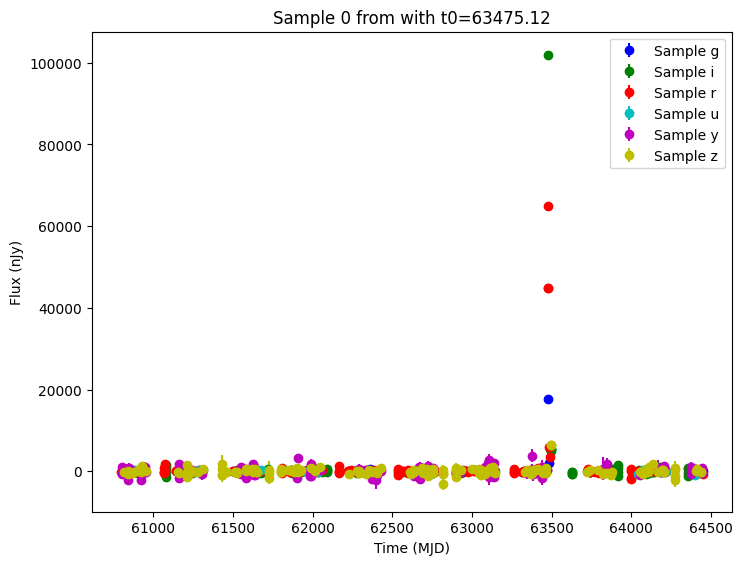

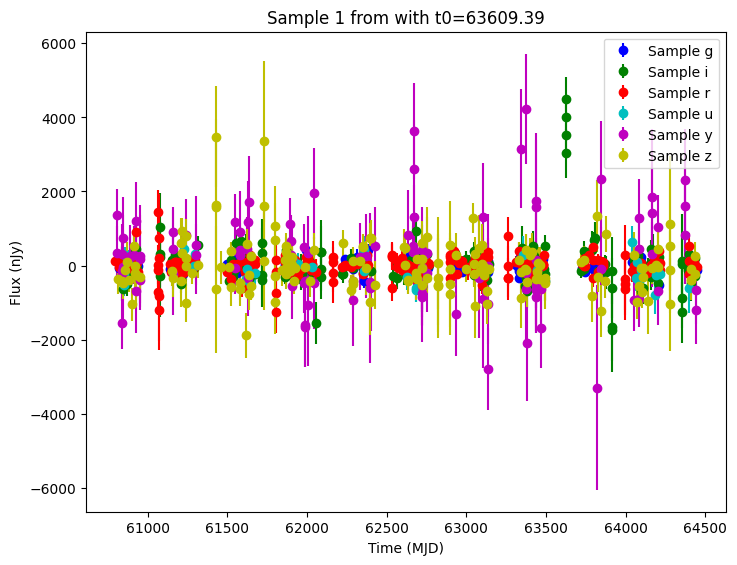

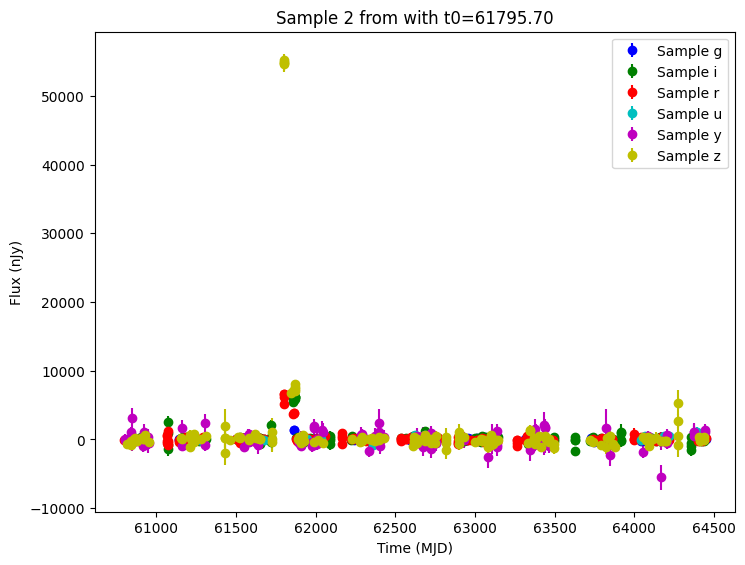

In [8]:
from lightcurvelynx.utils.plotting import plot_lightcurves
import matplotlib.pyplot as plt

# Reset the matplotlib configuration so it doesn't try to use latex
plt.rcParams.update(plt.rcParamsDefault)

for idx in range(3):
    # Extract the row for this object.
    lc = lightcurves.loc[idx]

    # Plot the lightcurves.
    ax = plot_lightcurves(
        fluxes=np.asarray(lc["lightcurve"]["flux"], dtype=float),
        times=np.asarray(lc["lightcurve"]["mjd"], dtype=float),
        fluxerrs=np.asarray(lc["lightcurve"]["fluxerr"], dtype=float),
        filters=np.asarray(lc["lightcurve"]["filter"], dtype=str),
        title=f"Sample {idx} from with t0={lc["t0"]:.2f}",
    )
    ax.legend()
    plt.show()

## Conclusion

This notebook shows how we can create a basic wrapper for the redback models. A full featured version can be found in ``models/redback_models.py``. It includes:
* additional data validation,
* the ability to specify the redback function by name (string),
* additional support for priors defined by the `bilby` package, and
* helper functions for computing the valid wavelength bounds.